# UAS – Liver Disorders (UCI BUPA)
Notebook ini sudah dirapikan agar **runtut** dan tiap langkah berada di **cell terpisah**.


## 0. Import library

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# (Opsional) gaya plot
plt.style.use("default")
sns.set_theme(style="whitegrid")


## 1. Load dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/liver-disorders/bupa.data"
columns = ["mcv", "alkphos", "sgpt", "sgot", "gammagt", "drinks", "selector"]

df = pd.read_csv(url, header=None, names=columns)

print("Original shape:", df.shape)
display(df.head())


Original shape: (345, 7)


,mcv,alkphos,sgpt,sgot,gammagt,drinks,selector
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2


## 2. Cek kondisi data (missing, duplikat, distribusi label)

In [3]:
print("\nInfo dataset:")
display(df.info())

print("\nMissing values per kolom:")
print(df.isnull().sum())

print("\nJumlah data duplikat:", df.duplicated().sum())

print("\nDistribusi label selector:")
print(df["selector"].value_counts())



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mcv       345 non-null    int64  
 1   alkphos   345 non-null    int64  
 2   sgpt      345 non-null    int64  
 3   sgot      345 non-null    int64  
 4   gammagt   345 non-null    int64  
 5   drinks    345 non-null    float64
 6   selector  345 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 19.0 KB


None


Missing values per kolom:
mcv         0
alkphos     0
sgpt        0
sgot        0
gammagt     0
drinks      0
selector    0
dtype: int64

Jumlah data duplikat: 4

Distribusi label selector:
selector
2    200
1    145
Name: count, dtype: int64


## 3. Data cleaning

In [4]:
dup_before = df.duplicated().sum()
df = df.drop_duplicates()
dup_after = df.duplicated().sum()

# Mapping label: 1 -> 0, 2 -> 1
df["selector"] = df["selector"].map({1: 0, 2: 1})

print("Duplicates before:", dup_before)
print("Duplicates after :", dup_after)
print("Cleaned shape    :", df.shape)

print("\nDistribusi label setelah mapping:")
print(df["selector"].value_counts())


Duplicates before: 4
Duplicates after : 0
Cleaned shape    : (341, 7)

Distribusi label setelah mapping:
selector
1    199
0    142
Name: count, dtype: int64


## 4. EDA (visualisasi)

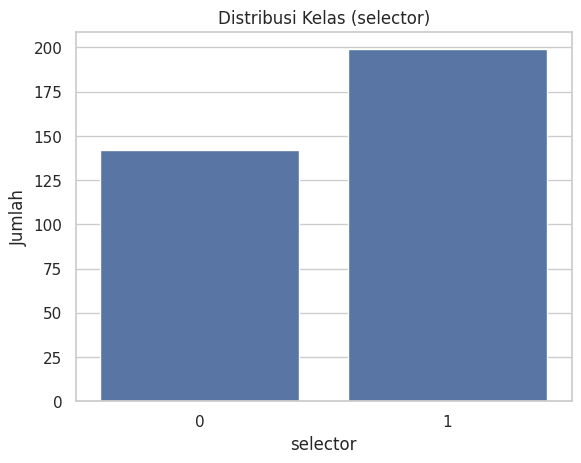

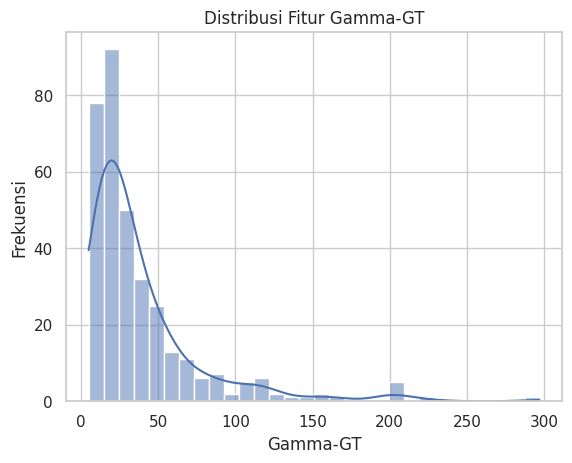

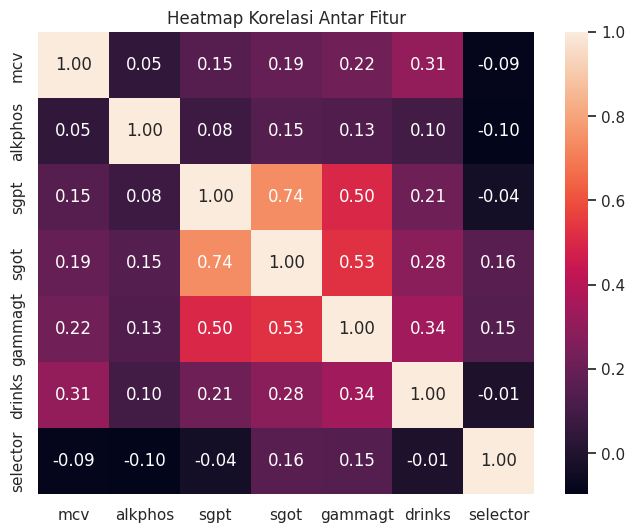

In [5]:
# 4.1 Distribusi kelas
plt.figure()
sns.countplot(x="selector", data=df)
plt.title("Distribusi Kelas (selector)")
plt.xlabel("selector")
plt.ylabel("Jumlah")
plt.show()

# 4.2 Histogram Gamma-GT
plt.figure()
sns.histplot(df["gammagt"], bins=30, kde=True)
plt.title("Distribusi Fitur Gamma-GT")
plt.xlabel("Gamma-GT")
plt.ylabel("Frekuensi")
plt.show()

# 4.3 Heatmap korelasi
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()


## 5. Split features & target + train/test split

In [6]:
X = df.drop("selector", axis=1)
y = df["selector"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (272, 6) Test shape: (69, 6)


## 6. Feature scaling (untuk Logistic Regression & MLP)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape :", X_test_scaled.shape)


Scaled train shape: (272, 6)
Scaled test shape : (69, 6)


## 7. Helper evaluasi (akurasi, precision, recall, F1 + report)

In [16]:
def eval_cls(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


## 8. Model 1 – Baseline: Logistic Regression

In [9]:
t0 = time.perf_counter()

model_baseline = LogisticRegression(
    C=1.0,
    solver="lbfgs",
    max_iter=200
)
model_baseline.fit(X_train_scaled, y_train)

t1 = time.perf_counter()
train_time_lr = t1 - t0

y_pred_lr = model_baseline.predict(X_test_scaled)

print("[Model 1] Logistic Regression training time (sec):", round(train_time_lr, 4))
metrics_lr = eval_cls(y_test, y_pred_lr, title="Logistic Regression (Baseline)")


[Model 1] Logistic Regression training time (sec): 0.027

=== Logistic Regression (Baseline) ===
Accuracy : 0.6957
Precision: 0.7021
Recall   : 0.8250
F1-score : 0.7586

Classification report:
              precision    recall  f1-score   support

           0     0.6818    0.5172    0.5882        29
           1     0.7021    0.8250    0.7586        40

    accuracy                         0.6957        69
   macro avg     0.6920    0.6711    0.6734        69
weighted avg     0.6936    0.6957    0.6870        69

Confusion matrix:
[[15 14]
 [ 7 33]]


## 9. Model 2 – Advanced ML: Random Forest

In [10]:
t0 = time.perf_counter()

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
model_rf.fit(X_train, y_train)

t1 = time.perf_counter()
train_time_rf = t1 - t0

y_pred_rf = model_rf.predict(X_test)

print("[Model 2] Random Forest training time (sec):", round(train_time_rf, 4))
metrics_rf = eval_cls(y_test, y_pred_rf, title="Random Forest (Advanced)")


[Model 2] Random Forest training time (sec): 0.5745

=== Random Forest (Advanced) ===
Accuracy : 0.7391
Precision: 0.7292
Recall   : 0.8750
F1-score : 0.7955

Classification report:
              precision    recall  f1-score   support

           0     0.7619    0.5517    0.6400        29
           1     0.7292    0.8750    0.7955        40

    accuracy                         0.7391        69
   macro avg     0.7455    0.7134    0.7177        69
weighted avg     0.7429    0.7391    0.7301        69

Confusion matrix:
[[16 13]
 [ 5 35]]


## 10. Model 3 – Deep Learning: MLP
### 10.1 Build model

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

input_dim = X_train_scaled.shape[1]

model_mlp = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model_mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

### 10.2 Train (>= 10 epochs) + catat training time

In [12]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

t0 = time.perf_counter()

history = model_mlp.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,               # >= 10
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

t1 = time.perf_counter()
train_time_mlp = t1 - t0

print("[Model 3] MLP training time (sec):", round(train_time_mlp, 4))


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5823 - loss: 0.6835 - val_accuracy: 0.6182 - val_loss: 0.6618
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5485 - loss: 0.6878 - val_accuracy: 0.6727 - val_loss: 0.6533
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5828 - loss: 0.6910 - val_accuracy: 0.6909 - val_loss: 0.6454
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5887 - loss: 0.6633 - val_accuracy: 0.6727 - val_loss: 0.6384
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6158 - loss: 0.6553 - val_accuracy: 0.6909 - val_loss: 0.6312
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6777 - loss: 0.6659 - val_accuracy: 0.6909 - val_loss: 0.6252
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6169 - loss: 0.6336 - val_accuracy: 0.7273 - val_loss: 0.6178
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6571 - loss: 0.6473 - val_accuracy: 0.7273 - val_loss

### 10.3 Plot loss & accuracy per epoch

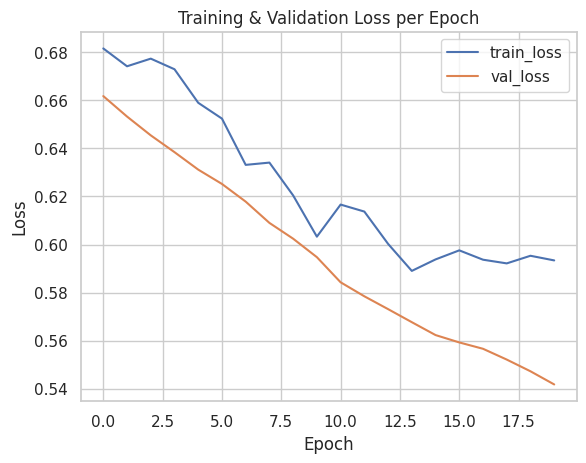

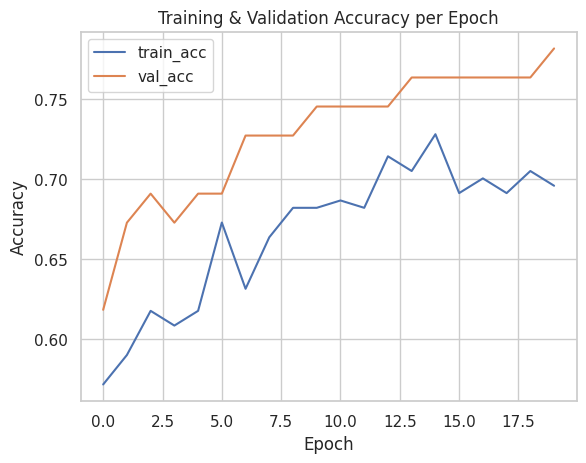

In [13]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### 10.4 Predict test set + evaluasi

In [14]:
y_pred_proba = model_mlp.predict(X_test_scaled).ravel()
y_pred_mlp = (y_pred_proba >= 0.5).astype(int)

metrics_mlp = eval_cls(y_test, y_pred_mlp, title="MLP (Deep Learning)")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

=== MLP (Deep Learning) ===
Accuracy : 0.7826
Precision: 0.7660
Recall   : 0.9000
F1-score : 0.8276

Classification report:
              precision    recall  f1-score   support

           0     0.8182    0.6207    0.7059        29
           1     0.7660    0.9000    0.8276        40

    accuracy                         0.7826        69
   macro avg     0.7921    0.7603    0.7667        69
weighted avg     0.7879    0.7826    0.7764        69

Confusion matrix:
[[18 11]
 [ 4 36]]


## 11. Ringkasan hasil (perbandingan 3 model)

In [15]:
results = pd.DataFrame([
    {"model": "Logistic Regression", "train_time_sec": train_time_lr, **metrics_lr},
    {"model": "Random Forest",       "train_time_sec": train_time_rf, **metrics_rf},
    {"model": "MLP (Deep Learning)", "train_time_sec": train_time_mlp, **metrics_mlp},
])

# Urutkan (opsional) berdasarkan F1 tertinggi
results_sorted = results.sort_values("f1", ascending=False).reset_index(drop=True)

print("=== Ringkasan Hasil ===")
display(results_sorted)


=== Ringkasan Hasil ===


,model,train_time_sec,accuracy,precision,recall,f1
0,MLP (Deep Learning),4.654213,0.782609,0.765957,0.900,0.827586
1,Random Forest,0.574521,0.739130,0.729167,0.875,0.795455
2,Logistic Regression,0.027004,0.695652,0.702128,0.825,0.758621


## 12. Save Models

Saving the trained models to disk for later use. We'll use `joblib` for scikit-learn models and `model.save()` for the Keras model.

In [17]:
import joblib

# Save Logistic Regression model
joblib.dump(model_baseline, 'logistic_regression_model.pkl')
print("Logistic Regression model saved as 'logistic_regression_model.pkl'")

# Save Random Forest model
joblib.dump(model_rf, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'")

# Save MLP model (Keras)
model_mlp.save('mlp_model.h5')
print("MLP model saved as 'mlp_model.h5'")

Logistic Regression model saved as 'logistic_regression_model.pkl'
Random Forest model saved as 'random_forest_model.pkl'
MLP model saved as 'mlp_model.h5'
